## **狗的品种识别（ImageNet Dogs）**
#### 选题来自Kaggle的一场比赛——[Dog Breed Identification](https://www.kaggle.com/c/dog-breed-identification)

 **与本文件同级目录下的`gradio.py`文件是本文件的一个部署版本，可以通过Gradio部署到网页上。通过输入犬类图片，利用预训练的ResNet-34模型，对犬类进行识别，并输出犬类的品种，同时调用文心一言大模型ErnieBot进行科普介绍。**
 **本项目预计会开源到我的[GitHub](https://github.com/Hpuer-lh)，欢迎老师批评指正。**

In [1]:
!pip install tqdm
!pip install d2l

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [2]:
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

#### 1. **获取和整理数据集**

**完整数据集类型说明：**

|    数据集类型     | 图像数量 | 图像格式 | 颜色通道 | 犬类种类数 | 犬类示例 |
|:------------:|:------------:|:------------:|:------------:|:------------:|:------------:|
|     训练集      | 10222张  | JPEG     | RGB      | 120种      | 拉布拉多等 |
|     测试集      | 10357张  | JPEG     | RGB      | 120种      | 同上      |

---

**精简版数据集类型说明：**

|    数据集类型     | 图像数量  | 图像格式 | 颜色通道 | 犬类种类数 | 犬类示例 |
|:------------:|:-----:|:------------:|:------------:|:-----:|:------------:|
|     训练集      | 1000张 | JPEG     | RGB      | 120种  | 拉布拉多等 |
|     测试集      |  10张  | JPEG     | RGB      |  10种  | 同上      |

##### **1.1 下载数据集**

**下载方式：**

---

下载[Kaggle](https://www.kaggle.com/c/dog-breed-identification/data)提供的完整版数据集

---

使用Kaggle API下载（‘kaggle competitions download -c dog-breed-identification’)

---

下载d2l提供的[精简版数据集](http://d2l-data.s3-accelerate.amazonaws.com/kaggle_dog_tiny.zip)

---

在../data中解压下载的文件后，将在以下路径中找到整个数据集：

**../data/dog-breed-identification/labels.csv**

**../data/dog-breed-identification/sample_submission.csv**

**../data/dog-breed-identification/train**

**../data/dog-breed-identification/test**

其中文件夹train/和test/分别包含训练和测试狗图像，labels.csv包含训练图像的标签,sample_submission.csv可以删除。


In [3]:
#数据集这里提供两种数据集，一种是小型数据集，另一种是Kaggle比赛的完整数据集，可以根据需要选择，这里默认使用小型数据集
d2l.DATA_HUB['dog_tiny'] = (d2l.DATA_URL + 'kaggle_dog_tiny.zip','0cb91d09b814ecdc07b50f31f8dcad3e81d6a86d')
# 如果使用Kaggle比赛的完整数据集，请将下面的变量更改为False
demo = False
if demo:
    data_dir = d2l.download_extract('dog_tiny')
else:
    data_dir = os.path.join('..', 'data', 'dog-breed-identification')
print("数据集路径：",data_dir,"数据集内容：",os.listdir(data_dir))

数据集路径： ../data/dog-breed-identification 数据集内容： ['train', 'train_valid_test', 'test', 'labels.csv', 'sample_submission.csv']


##### **1.2 整理数据集**

从原始训练集中拆分验证集，然后将图像移动到按标签分组的子文件夹中。

下面的reorg_dog_data函数读取训练数据标签、拆分验证集并整理训练集。

In [4]:
def reorg_dog_data(data_dir, valid_ratio):
    labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))#输入：文件路径，输出：带有标签的数据集
    d2l.reorg_train_valid(data_dir, labels, valid_ratio)#输入：文件路径，标签，验证集比例 输出：训练集和验证集
    d2l.reorg_test(data_dir)#输入：文件路径 输出：测试集

batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_dog_data(data_dir, valid_ratio)

#### **2. 图像增广**

图像增广（image augmentation）是一种在机器学习和计算机视觉领域常用的技术，它通过对训练图像进行一系列随机改变，来产生相似但又不同的训练样本，从而扩大训练数据集的规模。dog数据集是ImageNet数据集的子集，使用图像增广可以在这个小数据集上获得比较好的效果。

---

**transform_train**   用于训练集的图像增广和预处理。通过随机裁剪、水平翻转、亮度/对比度/饱和度调整等操作，生成多样化的训练样本，帮助模型更好地泛化。 

---

 **transform_test**    用于测试集的图像预处理。只进行确定性的操作（如调整大小和中心裁剪），确保测试图像的一致性，以便模型评估时的结果稳定可靠。 
 
---

In [5]:
transform_train = torchvision.transforms.Compose([
    # 随机裁剪图像，所得图像为原始面积的0.08～1之间，高宽比在3/4和4/3之间。
    # 缩放图像以创建224x224的新图像
    torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0),
                                             ratio=(3.0/4.0, 4.0/3.0)),
    # 随机水平翻转图像
    torchvision.transforms.RandomHorizontalFlip(),
    # 随机更改亮度，对比度和饱和度
    torchvision.transforms.ColorJitter(brightness=0.4,
                                       contrast=0.4,
                                       saturation=0.4),
    # 添加随机噪声
    torchvision.transforms.ToTensor(),
    # 标准化图像的每个通道
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

In [6]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    # 从图像中心裁切224x224大小的图片
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

#### **3. 读取数据集**

**1. 读取整理后的含原始图像文件的数据集**

---
|             |          |
|:---------------|:---------|
| train_ds       | 训练集数据    |
| train_valid_ds | 训练验证集数据  |
---
|||
|:---------|:------|
|valid_ds| 验证集数据 |
|test_ds| 测试集数据 |
---

In [7]:
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

**2. 创建数据加载器实例**

In [8]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, drop_last=True)
                                for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,drop_last=False)

**3. 保存数据集标签**

将标签保存到.csv文件中，以便在后续的训练和测试中使用。

In [9]:
import pandas as pd
output_csv = 'labels.csv'
# 保存标签为 .csv 文件
data = []
for class_name in train_valid_ds.classes:
    class_dir = os.path.join(data_dir, 'train_valid_test', 'train_valid', class_name)
    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            data.append([img_path, class_name])

df = pd.DataFrame(data, columns=['image_path', 'label'])
df.to_csv(output_csv, index=False)
print(f'标签已保存到 {output_csv}')

标签已保存到 labels.csv


#### **4. 微调预训练模型**

**1. 选择预训练的模型**

数据集:ImageNet数据集的子集

预训练模型:ResNet-34模型
步骤：
1. 选择预训练的模型
2. 使用该模型提取图像特征，以便将其输入到定制的小规模输出网络中
3. 重复使用此模型的输出层（即提取的特征）的输入
4. 用一个可以训练的小型自定义输出网络替换原始输出层

以下内容不重新训练用于特征提取的预训练模型，这节省了梯度下降的时间和内存空间。



In [10]:
def get_net(devices):
    finetune_net = nn.Sequential()
    # 使用预训练的ResNet-34模型来提取图像特征并且将其输入到定制的小规模输出网络中
    finetune_net.features = torchvision.models.resnet50(pretrained=True)
    # 定义一个新的输出网络替换原始输出层，以便对120个类别进行分类
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256),
                                            nn.ReLU(),
                                            nn.Linear(256, 120))
    # 将模型参数分配给用于计算的CPU或GPU
    finetune_net = finetune_net.to(devices[0])
    # 冻结参数，从而不重新训练用于特征提取的预训练模型
    for param in finetune_net.features.parameters():
        param.requires_grad = False
    return finetune_net

**2. 计算损失**

在计算损失之前，我们首先获取预训练模型的输出层的输入，即提取的特征。 然后我们使用此特征作为我们小型自定义输出网络的输入来计算损失。

In [11]:
loss = nn.CrossEntropyLoss(reduction='none')#交叉熵损失函数

def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0#初始化损失和样本数
    for features, labels in data_iter:
        features, labels = features.to(devices[0]), labels.to(devices[0])
        outputs = net(features)
        l = loss(outputs, labels)#计算损失
        l_sum += l.sum()
        n += labels.numel()
    return (l_sum / n).to('cpu')#返回平均损失

**3. 绘制图像**

使用 matplotlib 库来绘制训练过程中损失和准确率的变化图。

In [12]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, valid_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, 'bo-', label='Training loss')
    if valid_losses:
        plt.plot(epochs, valid_losses, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

#### **5. 定义训练函数**
其主要功能是训练一个微调的预训练模型并调整超参数，并在训练过程中评估其在验证集上的表现。具体步骤如下：

1. **模型并行化**：将模型并行化，并移动到指定设备（如 GPU）。
2. **定义优化器和学习率调度器**：使用随机梯度下降优化器和学习率调度器。
3. **初始化计时器和动画器**：用于记录训练时间和绘制损失曲线。
4. **训练循环**：遍历每个训练周期和批次，计算损失并更新模型参数。
5. **评估验证损失**：在每个周期结束时评估验证集上的损失。
6. **打印结果**：输出训练和验证损失，以及每秒处理的样本数。


In [13]:
from tqdm import tqdm

def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    '''
    输入：
    net：模型，
    train_iter：训练集，
    valid_iter：验证集，
    num_epochs：训练周期，
    lr：学习率，
    wd：权重衰减，
    devices：设备，
    lr_period：学习率调整周期，
    lr_decay：学习率调整率
    只训练小型自定义输出网络
    '''
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])  # 模型并行化
    trainer = torch.optim.SGD((param for param in net.parameters() if param.requires_grad), lr=lr,
                              momentum=0.9, weight_decay=wd)  # 定义优化器
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)  # 定义学习率调度器
    num_batches, timer = len(train_iter), d2l.Timer()  # 初始化计时器
    train_losses, valid_losses = [], []  # 初始化训练损失和验证损失
    for epoch in range(num_epochs):  # 训练循环周期
        metric = d2l.Accumulator(2)  # 初始化累加器，用于累加损失和样本数。
        with tqdm(total=num_batches, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:  # 进度条
            for i, (features, labels) in enumerate(train_iter):  # 遍历每个批次
                timer.start()
                features, labels = features.to(devices[0]), labels.to(devices[0])
                trainer.zero_grad()  # 梯度清零
                output = net(features)  # 前向传播
                l = loss(output, labels).sum()
                l.backward()  # 反向传播
                trainer.step()  # 更新参数
                metric.add(l, labels.shape[0])  # 累加损失和样本数
                timer.stop()
                pbar.update(1)
        train_loss = metric[0] / metric[1]  # 记录当前epoch的训练损失
        train_losses.append(train_loss)  # 将训练损失添加到列表中

        if valid_iter is not None:  # 如果有验证集，计算验证损失。
            valid_loss = evaluate_loss(valid_iter, net, devices)
            valid_losses.append(valid_loss.detach().cpu())
        scheduler.step()  # 更新学习率

    plot_metrics(train_losses, valid_losses if valid_iter is not None else None)  # 绘制训练和验证损失图
    print(f'train loss {train_loss:.3f}')
    if valid_iter is not None:  # 记录验证损失
        print(f'valid loss {valid_loss:.3f}')
    print(f'\n{metric[1] * num_epochs / timer.sum():.1f} examples/sec on {str(devices)}')

#### **6. 训练和验证模型**
以下超参数都是可调的

优化算法的学习速率=lr_period个迭代后乘以lr_decay


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch 50/50: 100%|██████████| 74/74 [01:10<00:00,  1.05batch/s]


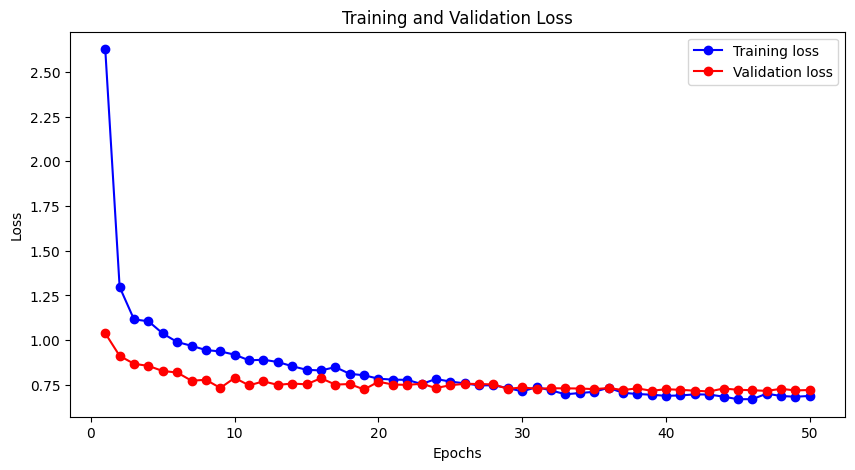

train loss 0.689
valid loss 0.722

1236.1 examples/sec on [device(type='cuda', index=0)]


In [14]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 50, 1e-4, 1e-4#定义设备，训练周期，学习率和权重衰减
lr_period, lr_decay, net = 2, 0.9, get_net(devices)#定义学习率调整周期和学习率调整率以及训练模型
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,lr_decay)
# 保存模型
torch.save(net.state_dict(), 'model.pth')

#### **7. 对测试集分类**
最终所有标记的数据（包括验证集）都用于训练模型和对测试集进行分类。
我们将使用训练好的自定义输出网络进行分类。

Epoch 50/50: 100%|██████████| 79/79 [01:15<00:00,  1.04batch/s]


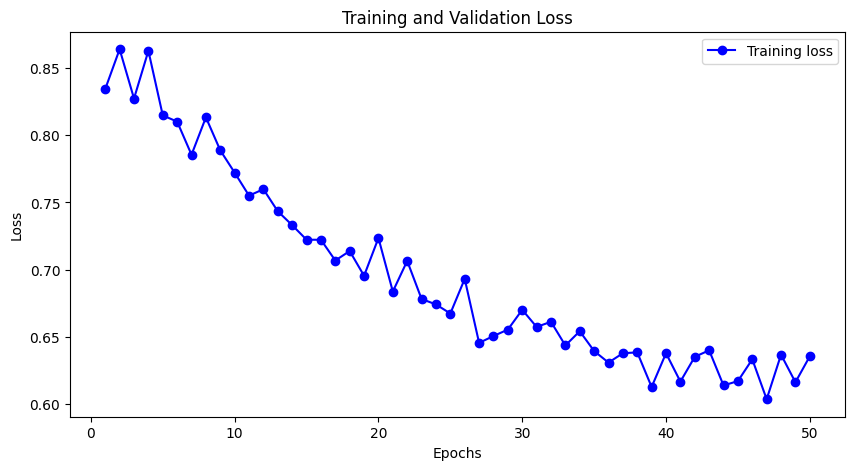

train loss 0.635

1236.4 examples/sec on [device(type='cuda', index=0)]


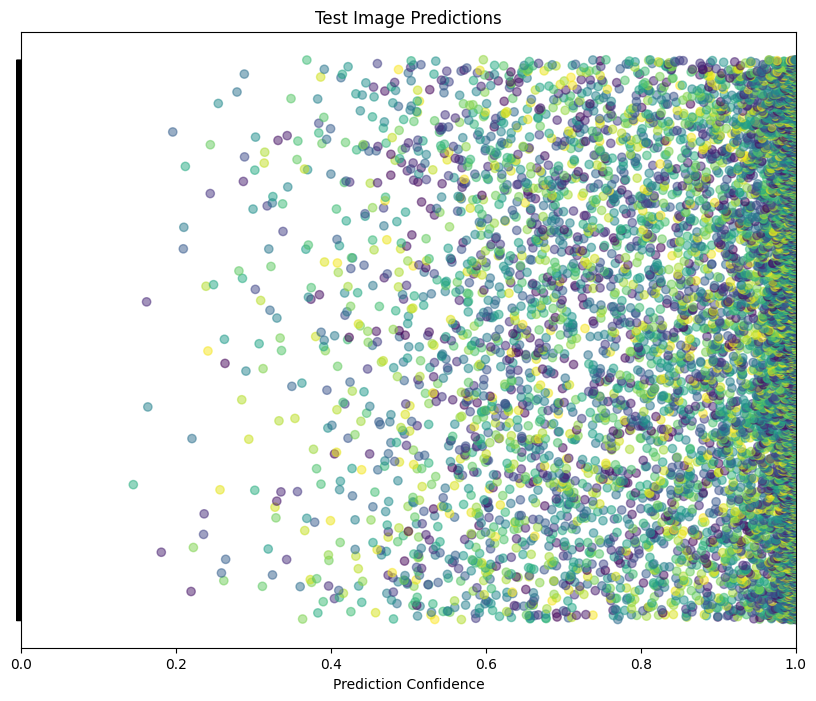

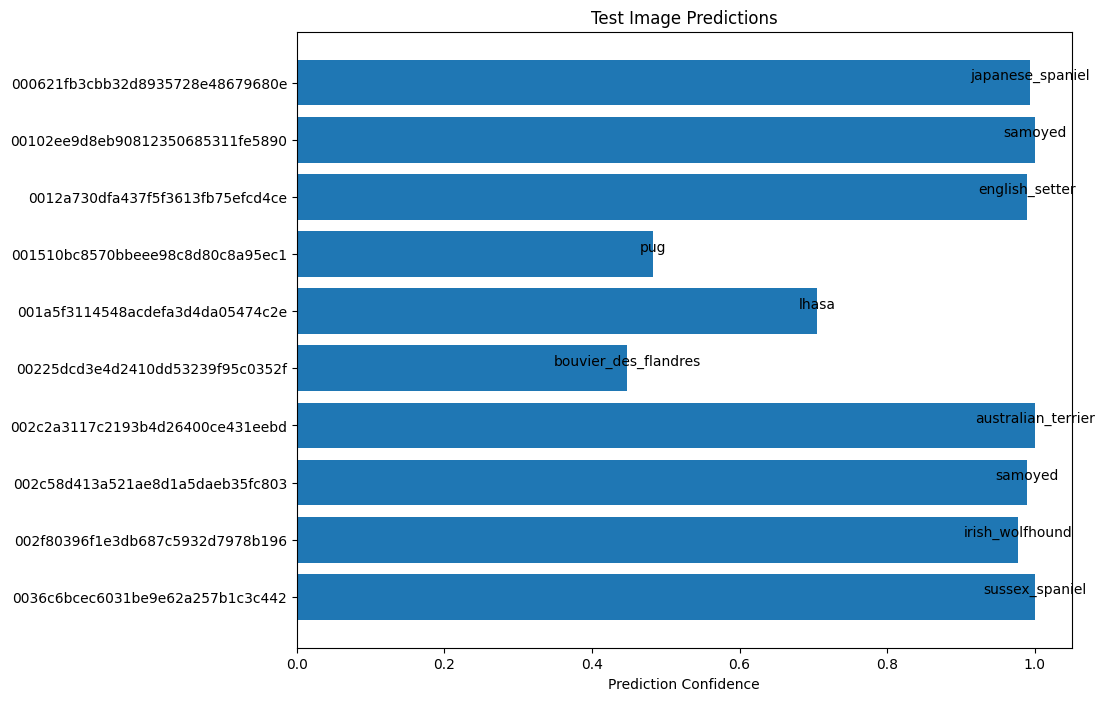

平均置信度: 0.86
90%以上所占比例: 70.00%
50%以下所占比例: 20.00%


In [15]:
import numpy as np

# 加载并使用模型
net = get_net(devices)
net.load_state_dict(torch.load('model.pth'))
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)

# 获取预测结果
preds = []
for data, label in test_iter:  # 遍历所有测试集样本
    output = torch.nn.functional.softmax(net(data.to(devices[0])), dim=1)
    preds.extend(output.cpu().detach().numpy())

# 获取测试集图像文件名
ids = sorted(os.listdir(os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')))
ids = ids[:len(preds)]  # 确保 ids 和 preds 的长度相同

# 定义类别
classes = train_valid_ds.classes

# 创建散点图
fig, ax = plt.subplots(figsize=(10, 8))
y_pos = np.arange(len(ids))
performance = [np.max(pred) for pred in preds]
log_performance = np.log1p(performance) / np.log1p(1)
# 绘制散点图
colors = np.random.rand(len(y_pos))  # 随机颜色
ax.scatter(log_performance, y_pos, c=colors, alpha=0.5)
# 设置x轴和y轴
ax.set_yticks(y_pos)
ax.set_yticklabels([])  # 不显示y轴标签
ax.set_xlim(0, 1)  # 设置x轴范围为0到1
ax.set_xlabel('Prediction Confidence')
ax.set_title('Test Image Predictions')
# 显示散点图
plt.show()

# 创建条形图
fig, ax = plt.subplots(figsize=(10, 8))
y_pos = np.arange(10)  # 只取前10个位置
performance = [np.max(pred) for pred in preds[:10]]  # 只取前10个预测结果
ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels([i.split('.')[0] for i in ids[:10]])  # 只取前10个图像文件名
ax.invert_yaxis()  # 反转Y轴，使得最高的值在顶部
ax.set_xlabel('Prediction Confidence')
ax.set_title('Test Image Predictions')
for i, pred in enumerate(preds[:10]):  # 只取前10个预测结果
    predicted_class = classes[np.argmax(pred)]
    ax.text(performance[i], i, predicted_class, ha='center', va='bottom')
# 显示条形图
plt.show()

# 计算平均置信度和各个置信度区间所占比例
mean_confidence = np.mean(performance)
above_90 = np.sum(np.array(performance) >= 0.9) / len(performance) * 100
below_50 = np.sum(np.array(performance) < 0.5) / len(performance) * 100

# 打印信息
print(f'平均置信度: {mean_confidence:.2f}')
print(f'90%以上所占比例: {above_90:.2f}%')
print(f'50%以下所占比例: {below_50:.2f}%')